# Final Project
Members: Joel Ampurdanés Bonjoch and Jordi Farrera Palou

# Introduction

In this project a Neural Network has been trained with different images of dogs breeds, so that given an image of a dog it can predict which breed it belongs to.

This Data contains 120 dog breeds which it has been selected 15 of them. So the Data has 2226 images for training and 556 for test. 

The 15 dog breeds are: 'afghan_hound',
 'african_hunting_dog',
 'basset',
 'beagle',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'chow',
 'dingo',
 'maltese_dog',
 'papillon',
 'rhodesian_ridgeback',
 'siberian_husky',
 'standard_poodle',
 'toy_terrier'



# Data preparation

This dataset didn't have train and test folders, so they have been created and the Data has been splitted, 80% for the train and 20% for the test.

Also, a lot of images have been removed because they contained humans, there were some dog breeds which had a different breed, and the images where the dog is far away, etc



# Dependencies

In [193]:
import math
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import requests
import scipy
import seaborn as sns

from google.colab import drive
from os import sep

# For images
import torch

from torch import nn
from torch import optim
from torch import randint
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR

from torchvision import datasets, transforms
from torch.utils import data

import helper
import torchvision

import torch.optim as optim

import torchvision.models as models

#Confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools



# General Functions

In [194]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [195]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch

        # move tensor to gpu
        if train_on_gpu:
          images = images.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

# Presets

In [196]:
#@title
FP_FOLDER = 'final-project'  # Your PAIA folder name

PROJECTS_ROUTE = 'drive' + sep + 'MyDrive' + sep + FP_FOLDER + sep 

PATH_TRAIN = 'train' + sep

PATH_TEST = 'test' + sep
PATH_VALID = 'valid' + sep 

In [197]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
%ls

Final-Project.ipynb  images/  test/  train/  valid/


In [199]:
%cd $PROJECTS_ROUTE

[Errno 2] No such file or directory: 'drive/MyDrive/final-project/'
/content/drive/.shortcut-targets-by-id/1NrhdcNSIq8uGUBVsHIQ3qXnBZtAEwafw/final-project


In [200]:
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

# Load images


## Tranforms: Image data processing

In [201]:
# convert data to a normalized torch.FloatTensor
transform_trains = transforms.Compose([
    #transforms.Grayscale(3), # convert the image to grayscale (black and white, 1 color channel)                                            
    #transforms.Resize((150,150)), # resize any image to 150x150
    #transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
    #transforms.ColorJitter(0.3,0.4,0.4,0.2),
    #transforms.ToTensor(),
    #transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    transforms.Resize((224,224)),
    transforms.CenterCrop(224), # randomly flip and rotate
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])

    ])



# Augmentation on test images not needed
transform_tests = transforms.Compose([
    #transforms.Grayscale(3), # convert the image to grayscale (black and white, 1 color channel)                                            
    #transforms.Resize((150,150)),
    #transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
    #transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

## Create Dataset

In [202]:
train_data = datasets.ImageFolder(PATH_TRAIN, transform=transform_trains)
test_data = datasets.ImageFolder(PATH_TEST, transform=transform_trains)

In [203]:
train_loader = data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

tensor(12) 16


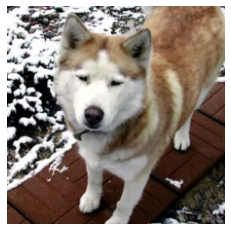

In [204]:
train_set, labels = next(iter(train_loader))

print(labels[0], len(train_set))
imshow(train_set[0], normalize=True)


In [205]:
train_data.classes

['afghan_hound',
 'african_hunting_dog',
 'basset',
 'beagle',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'chow',
 'dingo',
 'maltese_dog',
 'papillon',
 'rhodesian_ridgeback',
 'siberian_husky',
 'standard_poodle',
 'toy_terrier']

tensor(0) 1


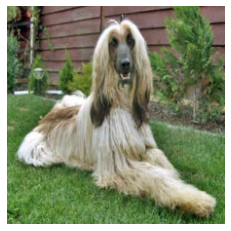

In [206]:
test_set, labels_test = next(iter(test_loader))

print(labels_test[0], len(test_set))
imshow(test_set[0], normalize=True)

# Import external GPU 

In [207]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [208]:
print(device)

cuda


# Calculate normalization values: Mean and std

In [209]:
mean = train_set[0].mean()

In [210]:
std = train_set[0].std()

# Create model

In [211]:
class CNN(nn.Module):
     
    # Definition of the constructor
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv_bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv_bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1) 
        self.conv_bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv_bn5 = nn.BatchNorm2d(128)
        
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256*28*28, 512)
        self.fc2 = nn.Linear(512, 15)

    
    # Definition of the forward function
    def forward(self, x):
       
        # Relu Conv Layer 1
        x = self.pool(F.relu(self.conv1(x)))
        
        # Relu Conv Layer 2
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        
        # Relu Conv Layer 3
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))

        # Relu Conv Layer 4
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        
        # Relu Conv Layer 5
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        
        x = self.conv_bn6(x)
        
        # Apply view function
        x = x.view(-1, 256 * 7 * 7)
        
        # Add dropout layer
        x = self.dropout(x)



        # Pass the first fully connected layer forward to the second
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        


        
        # Return output
        return x

This NN is to try new things and improve the model

In [212]:
class CNN2(nn.Module):
     
    # Definition of the constructor
    def __init__(self):
        
        super(CNN2, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
        self.conv_bn1 = nn.BatchNorm2d(3)

        
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv_bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv_bn3 = nn.BatchNorm2d(128)


        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256*28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 15)
        #self.fc4 = nn.Linear(128, 15)



    
    # Definition of the forward function
    def forward(self, x):
       
        # Relu Conv Layer 1
        x = self.conv_bn1(x)
        x = self.pool(F.relu(self.conv1(x), inplace=True))

        # Relu Conv Layer 2
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x), inplace=True))

        # Relu Conv Layer 3
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x), inplace=True))

        x = self.conv_bn6(x)
        
        # Apply view function
        #print("gordo", x.shape)
        x = x.view(-1, 256 * 28 * 28)
        
        # Add dropout layer
        x = self.dropout(x)

        # Pass the first fully connected layer forward to the second
        x = F.relu(self.fc1(x), inplace=True)
        x = self.dropout(x)
        x = F.relu(self.fc2(x), inplace=True)
        x = self.dropout(x)
        x = F.relu(self.fc3(x), inplace=True)
        #x = self.dropout(x)
        #x = F.relu(self.fc4(x))

        output = F.log_softmax(x, 1)
        
        


        
        # Return output
        return output

In [213]:
class CNN4(nn.Module):
     
    # Definition of the constructor
    def __init__(self):
        
        super(CNN4, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv_bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv_bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1) 
        self.conv_bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv_bn5 = nn.BatchNorm2d(128)
        
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256*7*7, 512)
        self.fc2 = nn.Linear(512, 15)

    
    # Definition of the forward function
    def forward(self, x):
       
        # Relu Conv Layer 1
        x = self.pool(F.relu(self.conv1(x)))
        
        # Relu Conv Layer 2
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        
        # Relu Conv Layer 3
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))

        # Relu Conv Layer 4
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        
        # Relu Conv Layer 5
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        
        x = self.conv_bn6(x)
        
        # Apply view function
        x = x.view(-1, 256 * 7 * 7)
        
        # Add dropout layer
        x = self.dropout(x)


        # Pass the first fully connected layer forward to the second
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        


        
        # Return output
        return x

## Initialize model

In [214]:
#model = CNN()
#model = CNN2()
model = CNN4()

In [215]:
print(model)

CNN4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2,

In [216]:
model.to(device)

CNN4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2,

# Specify loss function and optimizer

In [217]:
loss_function = nn.CrossEntropyLoss()
#loss_function = F.nll_loss

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train and test

## Train

In [218]:
def train(log_interval, model, train_loader, optimizer, epoch):
  model.train()
  train_loss = 0

  for batch_idx, (data, target) in enumerate(train_loader):

    if train_on_gpu:
      data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    # cosa per a transfer learning
    #target = target.unsqueeze(1)
    #target = target.float()

    output = model(data)

    loss = loss_function(output, target)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()*data.size(0)
   
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.sampler),
            100. * batch_idx / len(train_loader), loss.item()))
  print("Average loss", train_loss/len(train_loader.sampler))


## Test

In [219]:
def test(model, test_loader):
  test_loss = 0
  correct=0
  model.eval()
  for batch_idx, (data, target) in enumerate(test_loader):

      # move tensor to gpu
      if train_on_gpu:
          data, target = data.to(device), target.to(device)

      # forward pass: compute the validation predictions
      output = model(data)


      # cosa per a transfer learning
      #target = target.unsqueeze(1)
      #target = target.float()

      
      # calculate the loss
      loss = loss_function(output, target)

      # update the validation loss 
      test_loss += loss.item()*data.size(0)

      #print("outputtttttttttttttttt", output)
      
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      #print("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa", pred, target)

  test_loss /= len(test_loader.sampler)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.sampler),
      100. * correct / len(test_loader.sampler)))
  return test_loss, correct


## Prove model

In [220]:
# number of epochs for training set
epochs = 15
last_correct = -1
for epoch in range(1, epochs + 1):

  # Train the model
  train(10, model, train_loader, optimizer, epoch) # log_interval, model, device, !!training_data!!, optimizer, epoch

  # Validate the model
  test_loss, correct = test(model, test_loader)
  if last_correct < correct:
    last_correct = correct
    best_model = copy.deepcopy(model.state_dict())

  # update learning rate
  scheduler.step(test_loss)


Train Epoch: 1 [0/2226 (0%)]	Loss: 2.648326
Train Epoch: 1 [160/2226 (7%)]	Loss: 2.790913
Train Epoch: 1 [320/2226 (14%)]	Loss: 2.867278
Train Epoch: 1 [480/2226 (21%)]	Loss: 2.456450
Train Epoch: 1 [640/2226 (29%)]	Loss: 2.533732
Train Epoch: 1 [800/2226 (36%)]	Loss: 2.459612
Train Epoch: 1 [960/2226 (43%)]	Loss: 2.432799
Train Epoch: 1 [1120/2226 (50%)]	Loss: 2.098562
Train Epoch: 1 [1280/2226 (57%)]	Loss: 2.193889
Train Epoch: 1 [1440/2226 (64%)]	Loss: 2.555103
Train Epoch: 1 [1600/2226 (71%)]	Loss: 2.425869
Train Epoch: 1 [1760/2226 (79%)]	Loss: 1.919112
Train Epoch: 1 [1920/2226 (86%)]	Loss: 2.519977
Train Epoch: 1 [2080/2226 (93%)]	Loss: 1.903478
Average loss 2.329294847992231

Test set: Average loss: 1.9379, Accuracy: 206/556 (37%)

Train Epoch: 2 [0/2226 (0%)]	Loss: 2.283468
Train Epoch: 2 [160/2226 (7%)]	Loss: 2.284345
Train Epoch: 2 [320/2226 (14%)]	Loss: 1.797025
Train Epoch: 2 [480/2226 (21%)]	Loss: 1.948126
Train Epoch: 2 [640/2226 (29%)]	Loss: 1.740580
Train Epoch: 2 [800

# Evaluate Model

In [221]:
model.load_state_dict(best_model)

<All keys matched successfully>

## Test images prediction

In [222]:
correct_count, all_count = 0,0
for images, labels in test_loader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,224,224)
        with torch.no_grad():
            logps = model(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 556

 Model Accuracy= 75.53956834532374


### Image prediction

In [223]:
from PIL import Image
from torch.autograd import Variable

In [224]:
def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,150,150) to (1,3,150,150) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

In [225]:
from os.path import join
from os import listdir

pred_files = [join(PATH_VALID, f) for f in listdir(PATH_VALID)]

outcomes = listdir(PATH_TRAIN)

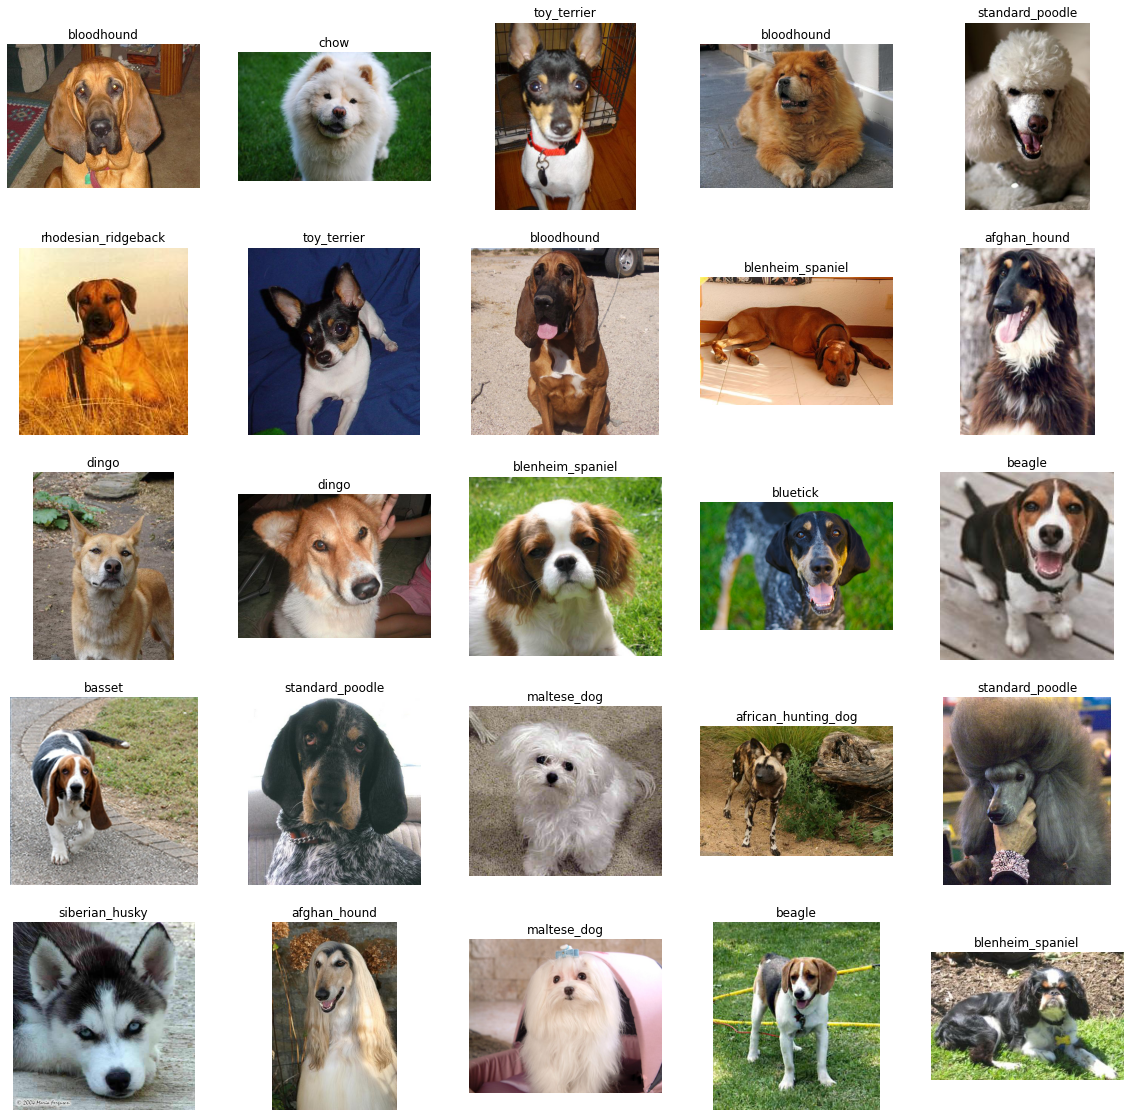

In [226]:
# make class dictionary so i can grab class name by index(key)
classes = {k:v for k , v in enumerate(sorted(outcomes))}
model.eval()


plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

## Confusion Matrix

In [227]:
with torch.no_grad():
    test_pred = get_all_preds(model, test_loader)

In [228]:
test_pred.argmax(dim=1)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 10, 10,  0,  0,  0,  6,  5,
         0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  4,  0,  3,
         6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         4,  4, 14,  2,  2, 12,  3,  2, 13, 10,  2, 14,  2,  3, 14,  2, 10,  1,
         2,  2, 14,  2,  1,  3,  9,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  5,  3,  5,  2,  5,  3,  3,  3,  5,  3,  3,  6,  3,  3,  1,
         2, 11,  3, 11,  3,  3, 14, 12,  3, 14, 12,  3,  7,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  7,  4,  4,  4,  4,  4,  3,  4,  6,  4,  2,  4,  6, 10,
         4,  4,  4,  9, 10, 12,  4,  3, 10,  4,  2,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  7, 11,  2,  5, 11,  5,  5,  5,  0,  5,  5, 11,
         5,  5,  1,  7,  8,  5,  1, 11, 

In [229]:
test_data_tensor = torch.tensor(test_data.targets).to(device)

In [230]:
stacked = torch.stack((test_data_tensor, 
                       test_pred.argmax(dim=1)), 
                      dim=1)

In [231]:
stacked.shape

torch.Size([556, 2])

In [232]:
cmt = torch.zeros(15,15, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [233]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [234]:
cm = confusion_matrix(test_data_tensor.cpu(), test_pred.argmax(dim=1).cpu())
cm

array([[27,  0,  0,  1,  1,  1,  4,  1,  0,  0,  2,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2, 28,  3,  2,  0,  0,  0,  0,  1,  2,  0,  1,  1,  4],
       [ 0,  1,  2, 25,  0,  4,  1,  1,  0,  0,  0,  2,  2,  0,  2],
       [ 0,  0,  2,  2, 22,  0,  2,  1,  0,  1,  3,  0,  1,  0,  0],
       [ 1,  2,  2,  0,  0, 22,  0,  2,  1,  0,  0,  4,  0,  0,  0],
       [ 2,  1,  1,  0,  0,  1, 23,  0,  0,  0,  0,  0,  1,  1,  3],
       [ 3,  0,  2,  0,  0,  5,  0, 32,  2,  3,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 27,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  0,  0,  0, 44,  0,  0,  1,  0,  1],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  1, 42,  1,  3,  0,  1],
       [ 2,  0,  4,  1,  1,  4,  0,  2,  1,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 42,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 32,  0],
       [ 1,  1,  3,  2,  0,  1,  0

Normalized confusion matrix


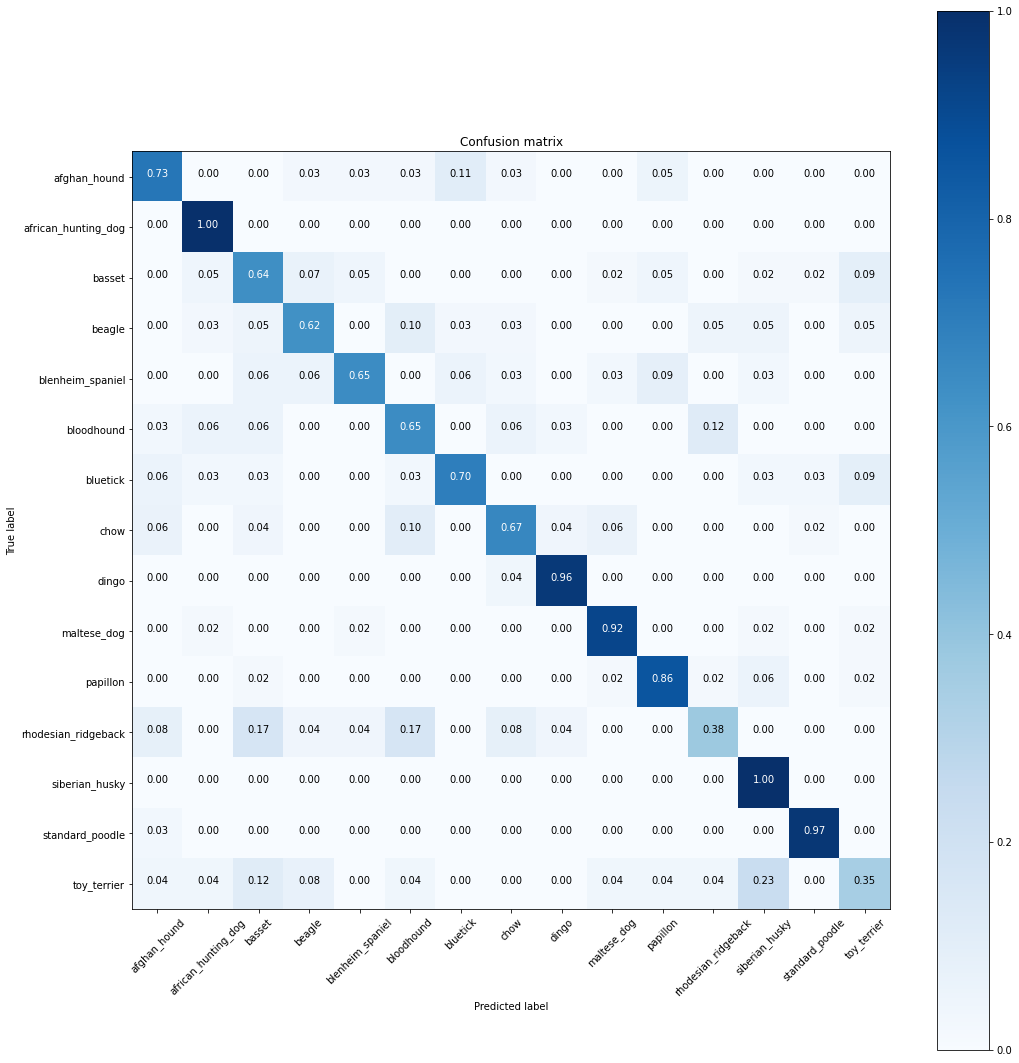

In [235]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, test_data.classes, normalize=True)

# Transfer Learning

In [236]:
#Loading vgg11 into the variable model_transfer
model_transfer = models.vgg11(pretrained=True)

In [237]:
#Freezing the parameters
for param in model_transfer.features.parameters():
    param.requires_grad = False
   
#Changing the classifier layer
model_transfer.classifier[6] = nn.Linear(4096,133,bias=True)
    
#Moving the model to GPU-RAM space
model_transfer = model_transfer.cuda()
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [238]:
### Loading the optimizer
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [240]:
# number of epochs for training set
epochs = 10
last_correct = -1
for epoch in range(1, epochs + 1):

  # Train the model
  train(10, model_transfer, train_loader, optimizer_transfer, epoch) # log_interval, model, device, !!training_data!!, optimizer, epoch

  # Validate the model
  test_loss, correct = test(model_transfer, test_loader)

  if last_correct < correct:
    last_correct = correct
    best_model = copy.deepcopy(model_transfer.state_dict())

  # update learning rate
  scheduler.step(test_loss)


Train Epoch: 1 [0/2226 (0%)]	Loss: 0.020598
Train Epoch: 1 [160/2226 (7%)]	Loss: 0.011867
Train Epoch: 1 [320/2226 (14%)]	Loss: 0.014373
Train Epoch: 1 [480/2226 (21%)]	Loss: 0.352420
Train Epoch: 1 [640/2226 (29%)]	Loss: 0.196713
Train Epoch: 1 [800/2226 (36%)]	Loss: 0.392882
Train Epoch: 1 [960/2226 (43%)]	Loss: 0.015280
Train Epoch: 1 [1120/2226 (50%)]	Loss: 0.224481
Train Epoch: 1 [1280/2226 (57%)]	Loss: 0.072572
Train Epoch: 1 [1440/2226 (64%)]	Loss: 0.119548
Train Epoch: 1 [1600/2226 (71%)]	Loss: 0.023446
Train Epoch: 1 [1760/2226 (79%)]	Loss: 0.060191
Train Epoch: 1 [1920/2226 (86%)]	Loss: 0.330163
Train Epoch: 1 [2080/2226 (93%)]	Loss: 0.459796
Average loss 0.12275123164251862

Test set: Average loss: 0.1254, Accuracy: 534/556 (96%)

Train Epoch: 2 [0/2226 (0%)]	Loss: 0.103598
Train Epoch: 2 [160/2226 (7%)]	Loss: 0.407183
Train Epoch: 2 [320/2226 (14%)]	Loss: 0.048840
Train Epoch: 2 [480/2226 (21%)]	Loss: 0.054225
Train Epoch: 2 [640/2226 (29%)]	Loss: 0.059396
Train Epoch: 2 [8

In [241]:
model_transfer.load_state_dict(best_model)

<All keys matched successfully>

In [255]:
correct_count, all_count = 0,0
for images, labels in test_loader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,224,224)
        with torch.no_grad():
            logps = model_transfer(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 556

 Model Accuracy= 98.20143884892086


In [243]:
def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,150,150) to (1,3,150,150) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model_transfer(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

In [244]:
from os.path import join
from os import listdir

pred_files = [join(PATH_VALID, f) for f in listdir(PATH_VALID)]

outcomes = listdir(PATH_TRAIN)

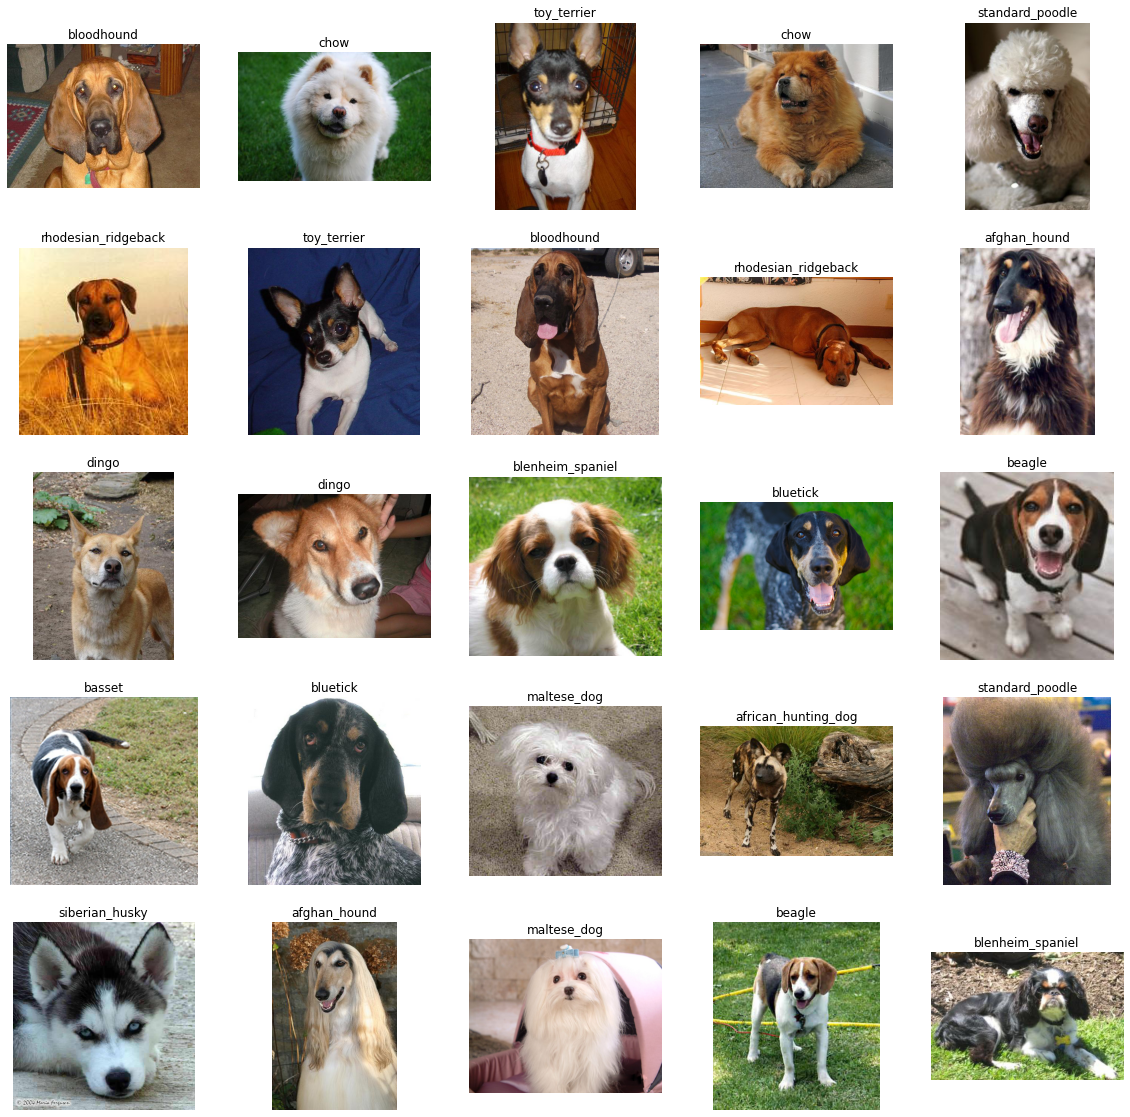

In [245]:
# make class dictionary so i can grab class name by index(key)
classes = {k:v for k , v in enumerate(sorted(outcomes))}
model_transfer.eval()


plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('off')
    plt.imshow(img)

## Evaluate Model

In [246]:
with torch.no_grad():
    test_pred = get_all_preds(model_transfer, test_loader)

In [247]:
test_pred.argmax(dim=1)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  0,  4,  4,  4,  4,  4, 12,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5, 

In [248]:
test_data_tensor = torch.tensor(test_data.targets).to(device)

In [249]:
stacked = torch.stack((test_data_tensor, 
                       test_pred.argmax(dim=1)), 
                      dim=1)

In [250]:
stacked.shape

torch.Size([556, 2])

In [251]:
cmt = torch.zeros(15,15, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [252]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [253]:
cm = confusion_matrix(test_data_tensor.cpu(), test_pred.argmax(dim=1).cpu())
cm

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 42,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 33,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 48,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 49,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 23,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 42,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0],
       [ 0,  0,  0,  0,  0,  0,  0

Normalized confusion matrix


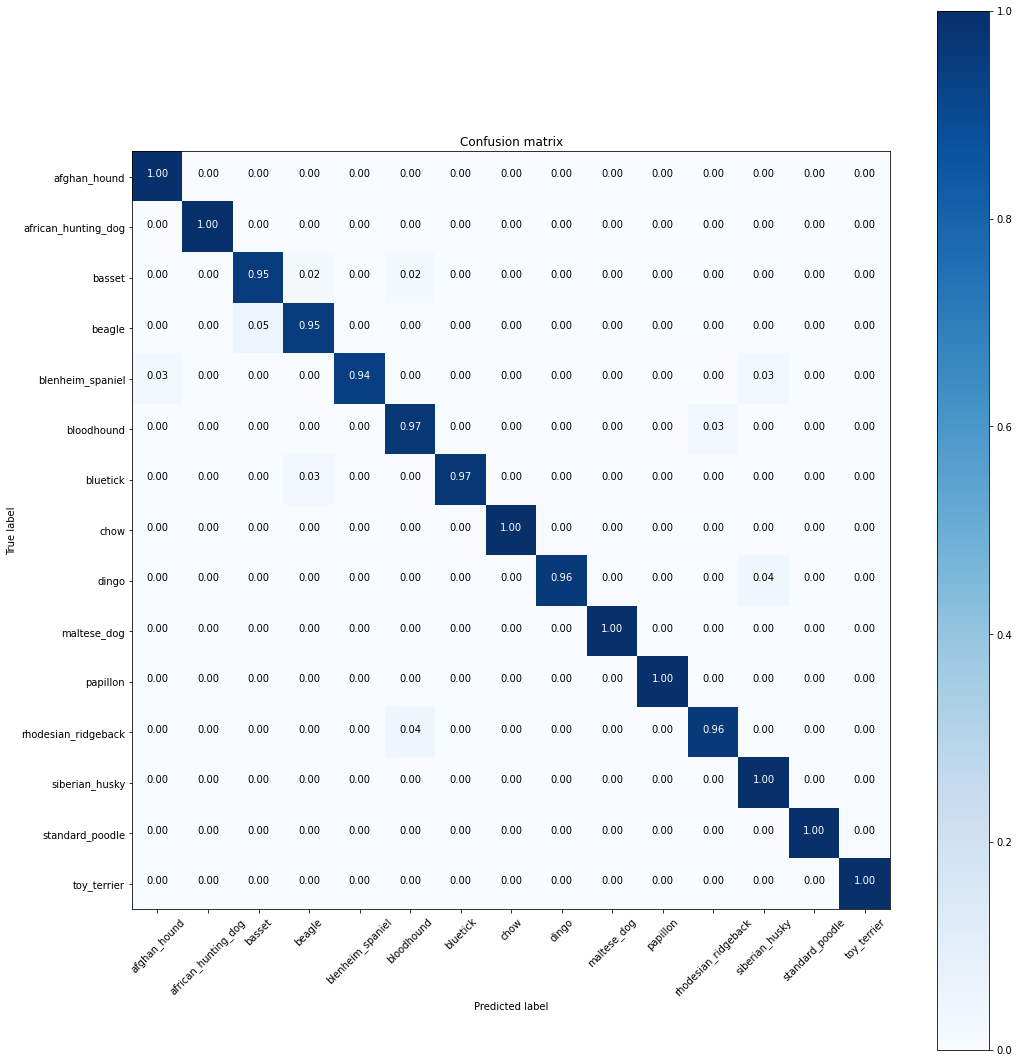

In [254]:
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, test_data.classes, normalize=True)

# Conclusions of the second submission

We train our model with 15-30-50-100 epochs, and the results that we achieve are between 40-64% accuracy. The problems that we have to achieve better results are, that some dog breeds are similar or the number of images for training. 